In [1]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
import pandas as pd

In [2]:
import os
os.chdir('D:\/Downloads-D')

### 1. Loading the data

In [3]:
#code taken from pcw: reading data from txt file
years = range(2011, 2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
usecols = [1, 2, 8] 

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)
data = pd.DataFrame(data)
data.head()

,0,1,2
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7


In [4]:
#renaming the columns
data = data.rename(columns={0: "Date", 1: "Hour", 2: "Temperature"})

In [5]:
data

,Date,Hour,Temperature
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7
...,...,...,...
631291,20161231.0,2340.0,0.3
631292,20161231.0,2345.0,0.2
631293,20161231.0,2350.0,0.0
631294,20161231.0,2355.0,-0.1


### 2.Preprocessing the data ###

Here, I preprocess the data to obtain the two variables needed for our models below: the minutes of the day, and the day of the year (in their respective orders). For example, February 1st is the 32nd day of the year.

Numerous preprocessing steps are required. First, we need to convert the "Date" column into three separate columns: year, month and day.

In [6]:
#Notice that the first four characters are always the years, the next two are the months, and the last two are the dates
#Create separate columns
years = []
months=[]
days=[]
for i in data['Date']:
    years.append(int(str(int(i))[0:4]))
    months.append(int(str(int(i))[4:6]))
    days.append(int(str(int(i))[6:8]))
data['Year']=years
data['Month']=months
data['Day']=days

In [7]:
data.head()

,Date,Hour,Temperature,Year,Month,Day
0,20110101.0,5.0,-6.4,2011,1,1
1,20110101.0,10.0,-6.5,2011,1,1
2,20110101.0,15.0,-6.5,2011,1,1
3,20110101.0,20.0,-6.5,2011,1,1
4,20110101.0,25.0,-6.7,2011,1,1


In [8]:
#Now, we need to convert the day into its order in a year
#To get the exact number, we need to convert each date into datetime format, then subtract by the first day of the year
from datetime import date
def date_convert(beginning_date, current_date):
    '''
    Function to convert a day into its order in that year
    inputs:
    beginning_date: list of 3 numbers: year, 1 and 1 (the first day of the first month of the year)
    current_date: list of 3 numbers: year, month and day of the day that we want to convert
    '''
    #First, convert both the dates into datetime format
    beginning_date = str(int(beginning_date[0]))+'-'+str(int(beginning_date[1]))+'-'+ str(int(beginning_date[2]))
    current_date = str(int(current_date[0]))+'-'+str(int(current_date[1]))+'-'+ str(int(current_date[2]))
    beginning_date=datetime.strptime(beginning_date,"%Y-%m-%d")
    current_date=datetime.strptime(current_date,"%Y-%m-%d")
    #Now, we will return the difference between the two dates
    return(abs(current_date-beginning_date).days+1)

#Testing
date_convert([2015,1,1], [2015,5,1])

121

In [9]:
#Now, we apply the function to all data values in the dataset
#First, we drop all NaN values
data = data.dropna()
#Now we apply the function:
data['Day_order'] = data.apply(lambda x: date_convert([x.Year,1,1], [x.Year,x.Month,x.Day]), axis=1)

In [10]:
data

,Date,Hour,Temperature,Year,Month,Day,Day_order
0,20110101.0,5.0,-6.4,2011,1,1,1
1,20110101.0,10.0,-6.5,2011,1,1,1
2,20110101.0,15.0,-6.5,2011,1,1,1
3,20110101.0,20.0,-6.5,2011,1,1,1
4,20110101.0,25.0,-6.7,2011,1,1,1
...,...,...,...,...,...,...,...
631291,20161231.0,2340.0,0.3,2016,12,31,366
631292,20161231.0,2345.0,0.2,2016,12,31,366
631293,20161231.0,2350.0,0.0,2016,12,31,366
631294,20161231.0,2355.0,-0.1,2016,12,31,366


We see values of "366" for year 2016, which is fine because 2016 is a leap year

In [11]:
#Finally, we need minutes. The data given is in HHmm, so we need to convert them to minutes. Same approach as above:
def convert_minutes(hour):
    '''
    Function to convert HHmm to minutes. Input:
    hour: the value given in the dataset: a number with the first two characters representing the hour, and the last
    two representing minutes
    '''
    minutes = (hour//100)*60 #(e.g. "2300" means the 23rd hour, so 23*60 is the minutes)
    residual_minute = hour%100
    minute_actual = minutes + residual_minute
    return minute_actual
#Testing
convert_minutes(2400) #True, a day has 1440 minutes

1440

In [12]:
#Now, we apply the function to all data values in the dataset
data['Minute_converted'] = data.Hour.apply(lambda x: convert_minutes(x))

In [13]:
data

,Date,Hour,Temperature,Year,Month,Day,Day_order,Minute_converted
0,20110101.0,5.0,-6.4,2011,1,1,1,5.0
1,20110101.0,10.0,-6.5,2011,1,1,1,10.0
2,20110101.0,15.0,-6.5,2011,1,1,1,15.0
3,20110101.0,20.0,-6.5,2011,1,1,1,20.0
4,20110101.0,25.0,-6.7,2011,1,1,1,25.0
...,...,...,...,...,...,...,...,...
631291,20161231.0,2340.0,0.3,2016,12,31,366,1420.0
631292,20161231.0,2345.0,0.2,2016,12,31,366,1425.0
631293,20161231.0,2350.0,0.0,2016,12,31,366,1430.0
631294,20161231.0,2355.0,-0.1,2016,12,31,366,1435.0


### 3. Fitting the models ###

In this section, I train the models and use them to predict the data. We will see below that including both Minutes and Days generated the highest r2 score, as opposed to only using them individually.

In [14]:
#First, we split the data into training and test set. Let's make 2011-2015 training, 2016 onwards test 
#The two variables we will include are day_order and minute_converted as required by the prompt
#Of course we include temperature as well which is our dependent variable
#First, we get rid of extreme temperature values
data = data[data["Temperature"]>-1000]
#Now we get the three needed columns
dataset_model = pd.DataFrame(data, columns=['Year','Temperature', 'Day_order', 'Minute_converted'])
dataset_model_train = dataset_model[dataset_model['Year']<2016]
dataset_model_test = dataset_model[dataset_model['Year']>=2016]
dataset_model_train

,Year,Temperature,Day_order,Minute_converted
0,2011,-6.4,1,5.0
1,2011,-6.5,1,10.0
2,2011,-6.5,1,15.0
3,2011,-6.5,1,20.0
4,2011,-6.7,1,25.0
...,...,...,...,...
525882,2015,-1.5,365,1415.0
525883,2015,-1.4,365,1420.0
525884,2015,-1.6,365,1425.0
525885,2015,-1.4,365,1430.0


In [15]:
dataset_model_train=dataset_model_train.drop(['Year'], axis=1)
dataset_model_test=dataset_model_test.drop(['Year'], axis=1)

In [16]:
#Get model inputs
X_train = dataset_model_train.drop(['Temperature'], axis=1)
y_train = dataset_model_train.drop(['Day_order','Minute_converted'], axis=1)
X_test = dataset_model_test.drop(['Temperature'], axis=1)
y_test = dataset_model_test.drop(['Day_order','Minute_converted'], axis=1)

In [17]:
y_test

,Temperature
525887,-1.6
525888,-1.9
525889,-2.0
525890,-2.1
525891,-2.2
...,...
631291,0.3
631292,0.2
631293,0.0
631294,-0.1


#### Fitting with only minutes

In [18]:
#Now we wrap input dimensions with rbfs
#First, we need the centers. For minutes, it's completely arbitrary, but I'll make the number of centers to be the number
#of hours in a day (so 24 centers)
centers_min = np.array(range(0, 1440, 60)).reshape(-1,1)

#After many testing times, I've settled with a sigma of 8000 - quite large for the model to wriggle around. Alpha=0.1
#I will go ahead with these values instead of testing in this notebook which clutters the work
sigma=8000
alpha=0.1

#wrapping in rbfs. We only deal with minutes here
minute_model_train = rbf_kernel(np.array(X_train.Minute_converted).reshape(-1,1), centers_min, gamma=1/sigma)
minute_model_test = rbf_kernel(np.array(X_test.Minute_converted).reshape(-1,1), centers_min, gamma=1/sigma)

#Fitting the model with Linear Regression
reg_minute = LinearRegression()
reg_minute.fit(minute_model_train, y_train)

#Testing the model
pred_minute = reg_minute.predict(minute_model_test)

In [19]:
from sklearn.metrics import r2_score
r2_score(y_test, pred_minute) #we see that the score is pretty low

0.04428047421561987

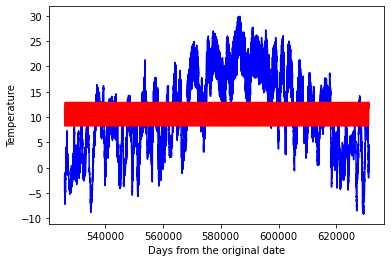

In [20]:
#Examining with a graph on the test data
plt.figure()
range_x = dataset_model_test.index
plt.plot(range_x, y_test, label='Real data', color='blue')
plt.plot(range_x, pred_minute, label='Predicted with minutes', color='Red')
plt.xlabel("Days from the original date")
plt.ylabel("Temperature")
plt.show()

We see that the fit is not good which explains the low R2 score. What this means is that Minutes do not explain much of the variation in temperature.

#### Fitting with only days

In [21]:
#Wrap input dimensions with rbfs
#First, we need the centers. For days, it's completely arbitrary, but I'll make the number of centers to be the number
#of months in a year (so 12)
centers_day = np.array(range(0, 365, 30)).reshape(-1,1)

#After many testing times, I've settled with a sigma of 8000 - quite large for the model to wriggle around. Alpha=0.1
#I will go ahead with these values instead of testing in this notebook which clutters the work
sigma=8000
alpha=0.1

#wrapping in rbfs. We only deal with minutes here
day_model_train = rbf_kernel(np.array(X_train.Day_order).reshape(-1,1), centers_day, gamma=1/sigma)
day_model_test = rbf_kernel(np.array(X_test.Day_order).reshape(-1,1), centers_day, gamma=1/sigma)

#Fitting the model with Linear Regression
reg_day = LinearRegression()
reg_day.fit(day_model_train, y_train)

#Testing the model
pred_day = reg_day.predict(day_model_test)

In [22]:
r2_score(y_test, pred_day) #We see here that r2 score is much higher than using only minutes

0.5739041508634215

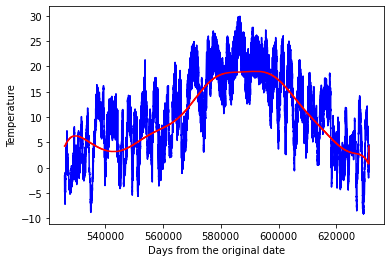

In [23]:
#Examining with a graph on the test data
plt.figure()
range_x = dataset_model_test.index
plt.plot(range_x, y_test, label='Real data', color='blue')
plt.plot(range_x, pred_day, label='Predicted with minutes', color='Red')
plt.xlabel("Days from the original date")
plt.ylabel("Temperature")
plt.show()

The fit is much better here! What this means is that even though Minutes do contribute to the variation, the variation is mostly explain by Days.

#### Fitting with both days and minutes

In [24]:
#Wrap input dimensions with rbfs
#First, we need the centers, which is a combination of the above models
centers_full = []
for i in range(0, 365, 30):
    for j in range(0, 1440, 60):
        centers_full.append([i,j])
centers_full=np.array(centers_full)
#After many testing times, I've settled with a sigma of 8000 - quite large for the model to wriggle around. Alpha=0.1
#I will go ahead with these values instead of testing in this notebook which clutters the work
sigma=8000
alpha=0.1

#wrapping in rbfs. We only deal with minutes here
full_model_train = rbf_kernel(X_train, centers_full, gamma=1/sigma)
full_model_test = rbf_kernel(X_test, centers_full, gamma=1/sigma)

#Fitting the model with Linear Regression
reg_full = LinearRegression()
reg_full.fit(full_model_train, y_train)

#Testing the model
pred_full = reg_full.predict(full_model_test)

In [25]:
r2_score(y_test, pred_full) #We see here that r2 score is higher than both of the above models

0.6240301491051408

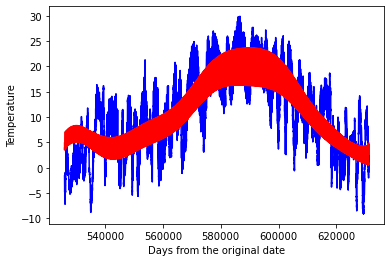

In [26]:
#Examining with a graph on the test data
plt.figure()
range_x = dataset_model_test.index
plt.plot(range_x, y_test, label='Real data', color='blue')
plt.plot(range_x, pred_full, label='Predicted with minutes', color='Red')
plt.xlabel("Days from the original date")
plt.ylabel("Temperature")
plt.show()

We see that including both variables allowed for a higher R2 score. This is reasonable because even though the variation is explained mostly by Days, it is also partly explained by Minutes. For example, we can see how temperatures will be lower in the winter and hotter in the summer. For days, temperature is usually highest at midday, for example.